In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyglstudy as gl
from pyglstudy.group_lasso import *
import numpy as np
import matplotlib.pyplot as plt

In [9]:
n = 100
p = 1000000
n_groups = int(p/100)
seed = 0

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_lasso_data(
    n, p, n_groups, rho=0, svd_transform=True
).values()

In [10]:
alpha = 1.0
penalty = np.ones(n_groups)
user_lmdas = [] #[1e-4, 1e-6]
max_n_lambdas = 100
n_lambdas_iter = 5
use_strong_rule = True
do_early_exit = True
verbose_diagnostic = False
delta_strong_size = 1
max_strong_size = p
max_n_cds = 100000
thr = 1e-8
newton_tol = 1e-8
newton_max_iters = 100000
min_ratio = 1e-2
n_threads = 16

In [11]:
%%time
out = gl.group_basil(
    X, y, groups, group_sizes, alpha, penalty, user_lmdas,
    max_n_lambdas,
    n_lambdas_iter,
    use_strong_rule,
    do_early_exit,
    verbose_diagnostic,
    delta_strong_size,
    max_strong_size,
    max_n_cds,
    thr,
    newton_tol,
    newton_max_iters,
    min_ratio,
    n_threads,
)

CPU times: user 3min 44s, sys: 23.9 s, total: 4min 8s
Wall time: 2min 39s


In [12]:
out['betas'], out['error'], np.array(out['rsqs']), np.array(out['lmdas'])

(<1000000x100 sparse matrix of type '<class 'numpy.float64'>'
 	with 179091 stored elements in Compressed Sparse Column format>,
 '',
 array([0.        , 0.08171389, 0.15938907, 0.23063737, 0.295974  ,
        0.35587534, 0.41078004, 0.46109351, 0.50718882, 0.54941057,
        0.58807565, 0.6234764 , 0.655882  , 0.68553984, 0.7126779 ,
        0.73750576, 0.76021612, 0.78098608, 0.79997836, 0.81734241,
        0.83321547, 0.84772347, 0.860982  , 0.87309703, 0.88416587,
        0.8942776 , 0.90351389, 0.91194966, 0.91965341, 0.92668802,
        0.93311093, 0.9389748 , 0.94432786, 0.94921413, 0.95367399,
        0.95774434, 0.96145891, 0.96484855, 0.96794149, 0.97076352,
        0.9733382 , 0.97568708, 0.97782983, 0.97978444, 0.98156736,
        0.98319355, 0.98467675, 0.98602946, 0.98726311, 0.98838813,
        0.98941405, 0.99034957, 0.99120261, 0.99198042, 0.99268962,
        0.99333624, 0.99392578, 0.99446327, 0.99495328, 0.99540001,
        0.99580726, 0.99617851, 0.99651694, 0.9968

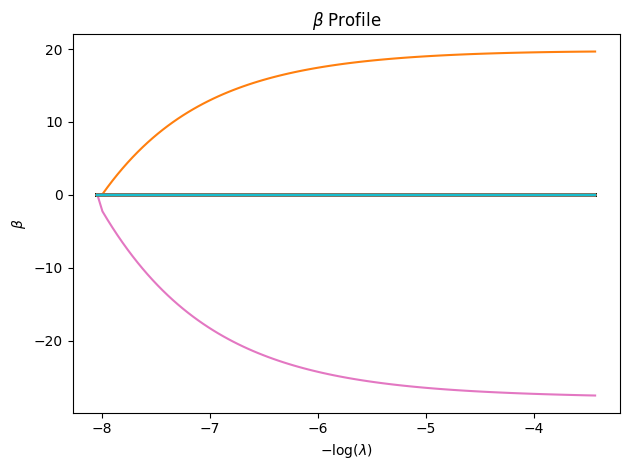

In [16]:
for j in range(out['betas'].shape[0]):
    if j % (p // 10000) == 0:
        plt.plot(-np.log(out['lmdas']), out['betas'][j].todense().reshape((-1,1)))
plt.title('$\\beta$ Profile')
plt.xlabel('$-\log(\lambda)$')
plt.ylabel('$\\beta$')
plt.tight_layout()
plt.show()